# *Fingerprint* ErG

Descrito em 2006 no artigo [ErG: 2D pharmacophore descriptions for scaffold hopping](https://pubmed.ncbi.nlm.nih.gov/16426057/), o *fingerprint* ErG (*Extended reduced graph*, grafos reduzidos estendidos) é um *fingerprint* molecular muito usado para busca por similaridade em bancos de dados. 

Diferente de outros *fingerprints* disponíveis no RDKit, como Morgan e RDKit, o cálculo do ErG considera **farmacóforos 2D** em vez de átomos. Para isso, as estruturas moleculares são convertidas a formas denominadas "grafos reduzidos" que, como o nome indica, simplificam a estrutura 2D enquanto preservam informações relevantes, como distâncias entre grupos funcionais e a natureza desses grupos (anéis aromáticos, grupos doadores/aceptores de ligação de hidrogênio, grupos hidrofóbicos). Essa representação pode fazer com que compostos semelhantes de acordo com o farmacóforo sejam identificados como similares pelo *fingerprint* ErG, ainda que apresentem baixa similaridade quando consideramos outros *fingerprints*, que consideram subestruturas.

Isso pode ser muito útil no processo denominado de *scaffold hopping*, que consiste em modificar a estrutura molecular "central" (*scaffold*) de um composto ativo sem perder as interações fundamentais com o alvo biológico. Esse processo pode ser usado para explorar estruturas novas, que não são protegidas por patentes, ou para "fugir" de estruturas que apresentam problemas como baixa solubilidade, alta flexibilidade, alto custo de síntese, etc.

Outra diferença é que o ErG *fingerprint* não é um vetor binário (0/1), o que não permite o cálculo do índice de Tanimoto usando a função `DataStructs.TanimotoSimilarity()` do RDKit. O artigo original sugere o uso de uma fórmula algébrica, implementada em uma função apresentada neste [blog post](https://iwatobipen.wordpress.com/2016/01/16/ergfingerprint-in-rdkit/), que discutiremos abaixo. Também usaremos boa parte do código disponibilizado pelo autor do *blog* para nosso exemplo.


In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw, PandasTools, rdReducedGraphs

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

O artigo [Scaffold hopping](https://www.sciencedirect.com/science/article/pii/S1740674904000460) destaca alguns exemplos de campanhas bem-sucedidas de *scaffold hopping*. Vamos explorar os compostos apresentados na Figura 1 do artigo:

In [2]:
smiles = {"Diazepam":"c1ccccc1C2=NCC(=O)N(C)c3ccc(Cl)cc23",
          "Zopiclone":"O=C(OC3c1nccnc1C(=O)N3c2ncc(Cl)cc2)N4CCN(C)CC4",
          "Zolpidem":"CN(C)C(=O)Cc1c(nc2ccc(C)cn12)c3ccc(C)cc3",
          "Zaleplon":"CCN(C(C)=O)c1cccc(-c2ccnc3c(C#N)cnn23)c1"}
mols = [Chem.MolFromSmiles(smi) for smi in smiles.values()]

Antes de calcularmos os índices de Tanimoto, veja se, visualmente, você consegue identificar alguma similaridade entre as estruturas selecionadas. Segundo os autores, elas foram desenvolvidas usando *scaffold hopping* nessa ordem: Diazepam → Zopiclone → Zolpidem → Zaleplon.

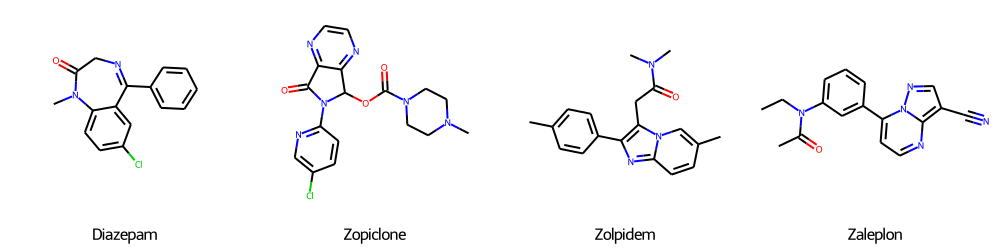

In [3]:
Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(250,250), legends=list(smiles.keys()))

O artigo que apresentou os *fingerprints* ErG mostra exemplos de geração de grafos reduzidos. O RDKit possui funcionalidade para gerar essas visualizações, mas elas são diferentes das propostas no artigo, e falham para algumas estruturas.

Veja abaixo como o RDKit representa o grafo reduzido do Diazepam:

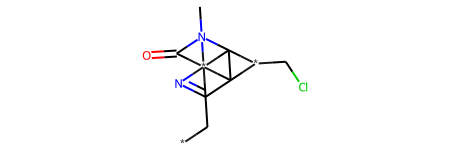

In [4]:
rdReducedGraphs.GenerateMolExtendedReducedGraph(mols[0])

Note que os anéis aromáticos são substituídos por asteriscos (no artigo, a representação é Ar). 

Os heteroátomos são mantidos nas suas posições relativas, porém, no artigo, são substituídos por Ac/D para representar a natureza de aceptor/doador de ligação de hidrogênio. 

Grupos hidrofóbicos são representados por Hf no artigo, mas não no RDKit.

Agora, vamos mostrar como gerar os *fingerprints* Morgan e ErG para as quatro estruturas e calcular a similaridade entre os pares.

Note que, diferentemente dos *fingerprints* Morgan, os *fingerprints* ErG não são vetores binários. Dessa forma, não é possível utilizar o índice de Tanimoto para determinar a similaridade entre eles. Porém, existem algumas medidas de similaridade que se aplicam a vetores contínuos que, quando aplicadas a vetores binários, correspondem ao índice de Tanimoto. Alguns exemplos são a *Ruzicka similarity* e a *similarity ratio* (ou *Kohonen similarity*). Vamos usar a última.

In [5]:
# Calcular fingerprints Morgan e ErG
morganfps = [AllChem.GetMorganFingerprintAsBitVect(mol,2) for mol in mols]
ergfps = [rdReducedGraphs.GetErGFingerprint(mol) for mol in mols]

In [6]:
molis = []
moljs = []

In [7]:
# Calcular o índice de Tanimoto para todos os pares de Morgan FP
morgantcs = [ ]

for i in range(len(morganfps)):
    for j in range(i+1, 4):
        molis.append( Chem.MolToSmiles(mols[i]) )
        moljs.append( Chem.MolToSmiles(mols[j]) )
        # O RDKit tem uma função para cálculo do índice de Tanimoto
        tc = DataStructs.TanimotoSimilarity( morganfps[i], morganfps[j] )
        morgantcs.append( tc )

In [8]:
# Função algébrica para cálculo da similarity ratio para os ErG fingerprints
def calc_ergfp( fp1, fp2 ):
    denominator = np.sum( np.dot(fp1,fp1) ) + np.sum( np.dot(fp2,fp2) ) - np.sum( np.dot(fp1,fp2 ))
    numerator = np.sum( np.dot(fp1,fp2) )
    return numerator / denominator

In [9]:
# Calcular similarity ratio para todos os pares de ErG FP
ergtcs = [ ]

for i in range( len(ergfps) ):
    for j in range(i+1, 4):
        tc = calc_ergfp( ergfps[i], ergfps[j] )
        ergtcs.append( tc )

In [10]:
# Nomes dos pares de estruturas comparadas
name_pairs = []
mol_names = list(smiles.keys())

for i in range(len(mol_names)):
    for j in range(i+1, 4):
        name_pairs.append(f"{mol_names[i]}, {mol_names[j]}")

In [11]:
# As colunas Morgan_sim e ErG_sim correspondem à similaridade calculada para o fingerprint correspondente
df = pd.DataFrame( {'Morgan_sim':morgantcs, 'ErG_sim':ergtcs, 'nomes':name_pairs, 'molis' : molis, 'moljs': moljs} )

# Adicionar coluna com objeto mol do RDKit - também mostra a imagem no DataFrame
PandasTools.AddMoleculeColumnToFrame( df, smilesCol='molis', molCol='ROMol_i')
PandasTools.AddMoleculeColumnToFrame( df, smilesCol='moljs', molCol='ROMol_j')

dfsummary = df[["Morgan_sim", 'ErG_sim', "nomes", "ROMol_i", "ROMol_j"] ]

,Morgan_sim,ErG_sim,nomes,ROMol_i,ROMol_j
0,0.202703,0.173182,"Diazepam, Zopiclone",,
1,0.132353,0.710145,"Diazepam, Zolpidem",,
2,0.155844,0.439076,"Diazepam, Zaleplon",,
3,0.125000,0.289047,"Zopiclone, Zolpidem",,
4,0.159091,0.496787,"Zopiclone, Zaleplon",,
5,0.153846,0.612562,"Zolpidem, Zaleplon",,

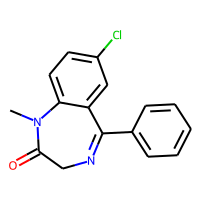
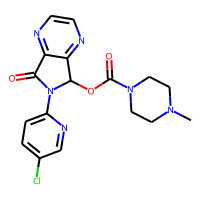
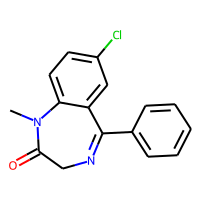
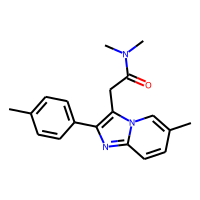
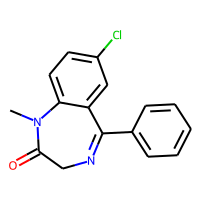
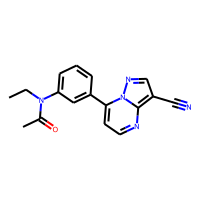
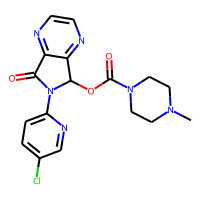
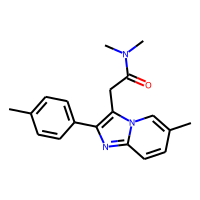
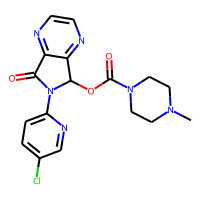
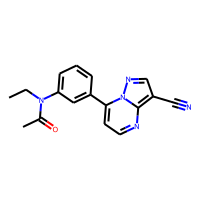
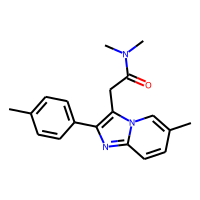
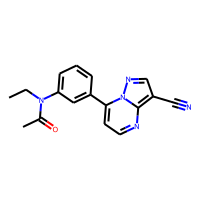

In [12]:
dfsummary

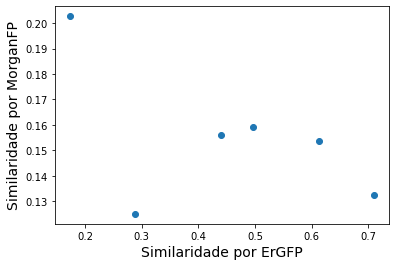

In [13]:
# Comparando as similaridades
plt.scatter(dfsummary['ErG_sim'], dfsummary["Morgan_sim"])
plt.xlabel("Similaridade por ErGFP", fontsize=14)
plt.ylabel("Similaridade por MorganFP", fontsize=14)
plt.show()

Veja que o *fingerprint* Morgan não identifica similaridade estrutural entre os compostos apresentados (índice de Tanimoto < 0.21 para todos os pares). Por outro lado, o *fingerprint* ErG consegue detectar similaridades entre os farmacóforos de alguns dos pares, atribuindo valores de similaridade mais altos a mais pares.